In [1]:
from linescanning import *
from prfpy import gauss2D_iso_cart
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.patches as patches

/mnt/d/FSL/shared/spinoza/programs/packages/prfpy/prfpy/model.py:5: FutureWarning: 

 | Starting with Nilearn 0.7.0, all Nistats functionality has been incorporated into Nilearn's stats & reporting modules.
 | Nistats package will no longer be updated or maintained.

  from nistats.hemodynamic_models import spm_hrf, spm_time_derivative, spm_dispersion_derivative


In [2]:
subject = 'sub-005'

params = utils.get_file_from_substring("best_vertices.csv", opj(os.environ['CTX'], subject))
params_df = pd.read_csv(params)
params_df = params_df.set_index('hemi')
params_df

,x,y,size,beta,baseline,r2,ecc,polar,index,position,normal
hemi,,,,,,,,,,,
L,2.282536,-7.416408e-01,1.038781,0.002219,-0.277978,0.720404,2.40,-0.314159,4386,[-24.061 -85.42 -21.133],[-0.578 -0.705 0.412]
R,-1.350000,1.653273e-16,1.038781,0.002593,-0.309637,0.772951,1.35,3.141593,5281,[ 6.738 -83.741 -15.439],[ 0.447 0.181 -0.876]


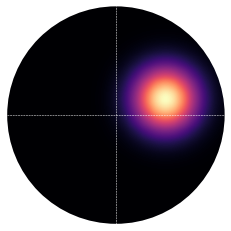

In [3]:
vf_extent = [-5, 5]
nr_vf_pix = 200
hemi = "L"
prf_space_x, prf_space_y = np.meshgrid(np.linspace(vf_extent[0], vf_extent[1], nr_vf_pix, endpoint=True),
                                        np.linspace(vf_extent[0], vf_extent[1], nr_vf_pix, endpoint=True))

cmap = utils.make_binary_cm(189,193,188)
prf = gauss2D_iso_cart(prf_space_x, prf_space_y, [params_df['x'][hemi],params_df['y'][hemi]],params_df['size'][hemi])

fig, ax = plt.subplots()
im = ax.imshow(prf, extent=vf_extent+vf_extent, cmap='magma')
ax.axvline(0, color='white', linestyle='dashed', lw=0.5)
ax.axhline(0, color='white', linestyle='dashed', lw=0.5)
patch = patches.Circle((0, 0), radius=vf_extent[-1], transform=ax.transData)
im.set_clip_path(patch)
ax.axis('off')

# fig.savefig(opj(os.path.dirname(params), 'better_prf.png'), transparant=True)
plt.show()

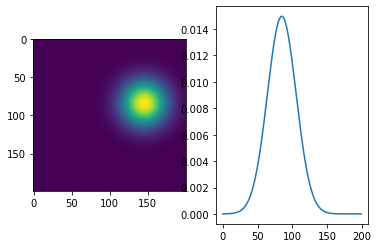

In [4]:
fig, axes = plt.subplots(ncols=2)
axes[0].imshow(prf)
axes[0].axis('image')

axes[1].plot(prf[:, np.where(prf == np.amax(prf))[0]])

plt.show()

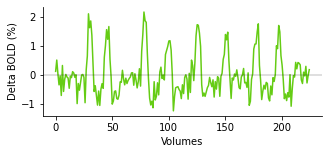

In [5]:
fig_tc = utils.show_tc(np.load(utils.get_file_from_substring('avg_bold_hemi-LR', opj(os.environ['PRF'], subject))), vertex=params_df['index'][0])

In [6]:
# fig_tc = utils.show_tc(np.load(utils.get_file_from_substring('avg_bold_hemi-LR', opj(os.environ['PRF'], subject))), vertex=params_df['index'][0], axes=False, save_img=opj(os.path.dirname(params), 'timecourse_no_axes.png'))

In [7]:
from prfpy.fit import Norm_Iso2DGaussianFitter,Iso2DGaussianFitter
from prfpy.model import Norm_Iso2DGaussianModel,Iso2DGaussianModel
from prfpy.stimulus import PRFStimulus2D
from scipy.io import loadmat

design_matrix = loadmat(opj(opj(os.environ['PRF'], subject), 'vis_design.mat'))

prf_stim = PRFStimulus2D(screen_size_cm=70,
                         screen_distance_cm=225,
                         design_matrix=design_matrix['stim'],
                         TR=1.5)

grid_nr = 20
max_ecc_size = 15
sizes, eccs, polars = max_ecc_size * np.linspace(0.125,1,grid_nr)**2, \
                        max_ecc_size * np.linspace(0.05,1,grid_nr)**2, \
                        np.linspace(0, 2*np.pi, grid_nr, endpoint=False)

# norm_bounds = [(-1.5*max_ecc_size, 1.5*max_ecc_size),  # x
#                 (-1.5*max_ecc_size, 1.5*max_ecc_size),  # y
#                 (eps, 1.5*ss),  # prf size
#                 (0, 1000),  # prf amplitude
#                 (0, 1000),  # bold baseline
#                 (0, 1000),  # surround amplitude
#                 (eps, 3*ss),  # surround size
#                 (0, 1000),  # neural baseline
#                 (1e-6, 1000)]  # surround baseline                        

gg =Iso2DGaussianModel(stimulus=prf_stim,
                             filter_predictions=False,
                             filter_type='sg',
                             filter_params={'window_length':300,'polyorder':1})                          
                        

In [10]:
data = np.load(utils.get_file_from_substring('avg_bold_hemi-LR', opj(os.environ['PRF'], subject)))[:,params_df['index'][hemi]]
data = data[...,np.newaxis]
data.shape

(225, 1)

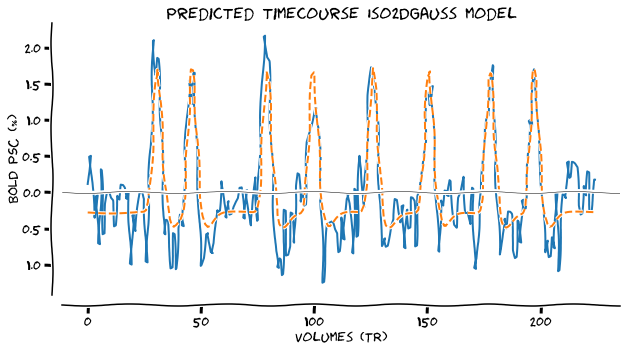

In [11]:
pred_iso = gg.return_prediction(params_df['x'][hemi],params_df['y'][hemi],params_df['size'][hemi],params_df['beta'][hemi],params_df['baseline'][hemi])
import seaborn as sns
with plt.xkcd():
    fig = plt.figure(figsize=(10,5))

    x = np.arange(0,pred_iso.shape[-1],1)[...,np.newaxis]
    plt.plot(x,data0,)
    plt.plot(x,pred_iso.T, '--')
    plt.axhline(0, color='k', lw=0.5)
    fig.gca().spines['top'].set_visible(False)
    fig.gca().spines['right'].set_visible(False)

    sns.despine(offset=10)

    fig.gca().set_xlabel("Volumes (TR)")
    fig.gca().set_ylabel("BOLD PSC (%)")
    fig.gca().set_title("Predicted timecourse Iso2DGauss model")


In [12]:
params = np.array([[ 2.283,-0.742,1.039,0.189,-0.163,0.01,18.,0.189,1.,0.745]])

In [15]:
gg = Norm_Iso2DGaussianModel(stimulus=prf_stim,
                             filter_predictions=False,
                             filter_type='sg',
                             filter_params={'window_length':300,'polyorder':1})

In [ ]:
# gf = Norm_Iso2DGaussianFitter(gg, data.T)
# old_params = np.array((params_df['x'][hemi],params_df['y'][hemi],params_df['size'][hemi],params_df['r2'][hemi]))[np.newaxis,...]

# surround_amplitude_grid=np.array([0.01,0.1,1,10], dtype='float32')
# surround_size_grid=np.array([5,8,12,18], dtype='float32')
# neural_baseline_grid=np.array([0,1,10,100], dtype='float32')
# surround_baseline_grid=np.array([0.1,1.0,10.0,100.0], dtype='float32')

# gf.grid_fit(surround_amplitude_grid, surround_size_grid, neural_baseline_grid,surround_baseline_grid, gaussian_params=old_params, n_batches=data.shape[-1])

In [17]:
# # iterative fit

# eps = 1e-1
# ss = prf_stim.screen_size_degrees
# xtol = 0.00001
# ftol = 0.00001
# constraints_norm = []
# rsq_threshold = 0.05

# norm_bounds = [(-1.5*max_ecc_size, 1.5*max_ecc_size),   # x
#                 (-1.5*max_ecc_size, 1.5*max_ecc_size),  # y
#                 (eps, 1.5*ss),                          # prf size
#                 (0, 1000),                              # prf amplitude       = A term
#                 (0, 1000),                              # bold baseline
#                 (0, 1000),                              # surround amplitude  = C term
#                 (eps, 3*ss),                            # surround size
#                 (0, 1000),                              # neural baseline     = B term
#                 (1e-6, 1000)]                           # surround baseline   = D term

# gf.iterative_fit(rsq_threshold=rsq_threshold, 
#                  verbose=False,
#                  bounds=norm_bounds,
#                  constraints=constraints_norm,
#                  xtol=xtol,
#                  ftol=ftol)

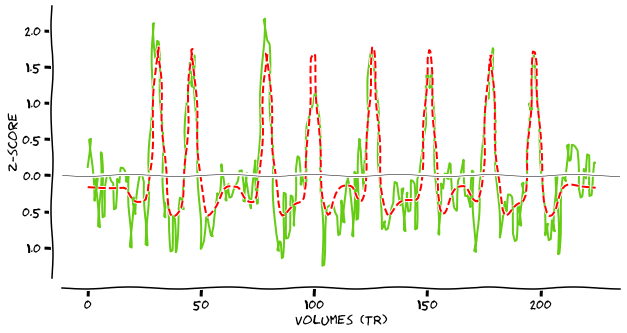

In [29]:
# # params = gf.iterative_search_params
# print(params)
# The asterisk in front of params expands the iterable so that its elements are the values of the parameters mu_x,mu_y etc.
# https://stackoverflow.com/questions/14518314/passing-a-list-as-positional-arguments-to-a-function-like-python-in-f
tc_pred = gg.return_prediction(*params[0])

import seaborn as sns

cartoon = True
with plt.xkcd():
    fig = plt.figure(figsize=(10,5))

    x = np.arange(0,tc_pred.shape[-1],1)[...,np.newaxis]
    plt.plot(x,data,color="#65CC14")
    plt.plot(x,tc_pred.T, '--', color="#FF0000")
    plt.axhline(0, color='k', lw=0.5)
    fig.gca().spines['top'].set_visible(False)
    fig.gca().spines['right'].set_visible(False)

    sns.despine(offset=10)

    fig.gca().set_xlabel("Volumes (TR)")
    fig.gca().set_ylabel("z-score")
    # fig.gca().set_title("Predicted timecourse Norm2DGauss model")
    fig.savefig(opj(os.environ['CTX'], subject, 'predicted_timecourse.png'))

In [64]:
print(f'surround size = {params[0][6]}')

surround size = 24.00065054301983
